In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing


In [1]:
npzfile = os.path.join(os.getcwd(), '../dataset/', 'movieAll')
npz = np.load(npzfile + '.npz')
imdb = npz['imdb']
tmdb = npz['tmdb']
match = npz['match']

size = match.size

In [2]:
import gensim 
from gensim.models import KeyedVectors
#Load Google's pre-trained Word2Vec 
model = KeyedVectors.load_word2vec_format('../dataset/embeddings/GoogleNews-vectors-negative300.bin', binary=True) 

In [4]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
#     if len(txt) > 2:
    return ' '.join(txt)

In [5]:
def movieEmbed(movieSet, emb_dim=300, attr_num=5):
    t = time()
    movie_list = []
    word_dims = [20, 10, 10, 10, 40]
    for movie in movieSet:
        movie_attr = []
        attr_count = 0
        brief_cleaning = (re.sub("[^A-Za-z0-9]+", ' ', str(row)).lower() for row in movie)
        movie_txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
        for attr, word_dim in zip(movie_txt, word_dims):
#             attr_list = []
            attr_count += 1
            if attr_count > attr_num:
                break
            movie_attr.append(np.zeros(300)[:emb_dim])
            movie_attr.append(np.zeros(300)[:emb_dim])
            zero_i = 0
            for attr_word in attr.split():
#                 print(attr_word)
                attr_vector = []
                try:
                    int(attr_word)
                    for char in attr_word:
                        attr_vector = model[char][:emb_dim]
#                         print(char, "  ", attr_vector[:2])
                        movie_attr.append(attr_vector)
                        zero_i += 1
                        if zero_i >= word_dim:
                            break
                except:
                    try:
                        attr_vector = model[attr_word][:emb_dim]
                    except:
                        attr_vector = np.ones(300)[:emb_dim]
#                         attr_vector = np.zeros(300)[:emb_dim]
#                     print(attr_word, "  ", attr_vector[:2])
                    movie_attr.append(attr_vector)
                    zero_i += 1
                if zero_i >= word_dim:
                    break
            for i in range(word_dim-zero_i):
                movie_attr.append(np.zeros(300)[:emb_dim])
#             movie_attr.append(attr_list)
        movie_attr.append(np.zeros(300)[:emb_dim])
        movie_attr.append(np.zeros(300)[:emb_dim])
        movie_list.append(movie_attr)

#     print(movie_list)

    print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
    return movie_list

In [3]:
from sklearn.model_selection import train_test_split


num_sta = 0
num_end = 20000

imdb_embed = movieEmbed(imdb[num_sta:num_end,:], attr_num=5)
tmdb_embed = movieEmbed(tmdb[num_sta:num_end,:], attr_num=5)

input12 = []

for movie1, movie2 in zip(imdb_embed, tmdb_embed):
    input12.append((movie1, movie2))
output = match[num_sta:num_end]

X_train, X_test, Y_train, Y_test = train_test_split(input12, output, train_size=0.9)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [7]:
# print(np.shape(X_train))
# for item in X_train:
#     print(len(item))
#     for movie in item:
#         print(len(movie))
#         break
# X_train = np.array(X_train)
# X_test = np.array(X_test)

In [8]:
# X_train.shape[0]

In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [2]:
class RLCNN(nn.Module):

    def __init__(self, word_embed):
        super(RLCNN, self).__init__()

        self.convEmbed = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 300), padding=0, stride=1)
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 153), padding=1, stride=1)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 143), padding=1, stride=1)
#         self.fc1 = nn.Linear(16 * 50, 100)  # 6*6 from image dimension
        self.fc1 = nn.Linear(16 * 21, 100)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        self.word_embed = word_embed
        
    def forward(self, x):
#         print("input x:", np.shape(x))
#         x = F.max_pool2d(F.relu(self.convEmbed(x)), kernel_size=(self.word_embed+2, 1), stride=(self.word_embed+2, 1), padding=0) 
#         x = F.dropout(x, p=0.5)
#         print("convEmbed x:", np.shape(x), " kernel: ", self.word_embed+2)
        x = F.max_pool2d(F.relu(self.convEmbed(x)), kernel_size=(2, 1), stride=(2, 1), padding=0) 
#         x = F.max_pool2d(F.relu(self.convEmbed(x)).reshape(100,1,16,100), kernel_size=(16, 1), stride=(1, 1), padding=0) 
        
#         x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=3, padding=1, stride=1)
#         x = F.dropout(x, p=0.5)
#         print("conv1 x:", np.shape(x))
#         x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=3, padding=1, stride=1)
#         x = F.dropout(x, p=0.5)
#         print("conv2 x:", np.shape(x))
        x = x.view(-1, self.num_flat_features(x))
#         print("num_flat_features x:", np.shape(x))
        x = self.fc1(x)
#         x = F.dropout(x, p=0.5)
#         print("fc1 x:", np.shape(x))
#         x = self.fc2(x)
#         x = F.dropout(x, p=0.5)
#         print("fc2 x:", np.shape(x))
        x = self.fc3(x)
#         x = F.dropout(x, p=0.5)
#         print("fc3 x:", np.shape(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """

        self.convEmbed.reset_parameters()
#         self.conv1.reset_parameters()
#         self.conv2.reset_parameters()
        self.fc1.reset_parameters()
#         self.fc2.reset_parameters()
        self.fc3.reset_parameters()

In [3]:
class SiameseCNN(nn.Module):

    def __init__(self):
        super(SiameseCNN, self).__init__()
        
        self.cnn = RLCNN(word_embed=10)
        self.fc1 = nn.Linear(10, 2)
        self.sm = nn.Softmax(dim=1)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        
    def forward(self, x, y):
#         x11 = x[:,0,:,:].reshape(100,1,512,300)
#         x12 = x[:,1,:,:].reshape(100,1,512,300)
#         print("In SiameseCNN: y: ", y[0])
#         print("In SiameseCNN: x: ", x[0,0,1:], "  ", x11[0,0,1:])
#         print("In SiameseCNN: x: ", x[0,1,1:], "  ", x12[0,0,1:])
        x1 = self.cnn(x[:,0,:,:].reshape(100,1,44,300))
#         print("In SiameseCNN: x1.shape: ", np.shape(x1))
#         with torch.no_grad():
        x2 = self.cnn(x[:,1,:,:].reshape(100,1,44,300))
#             print("In SiameseCNN: x2.shape: ", np.shape(x2))
#         for movie1, movie2 in zip(x1, x2):
#             input12.append((movie1, movie2))
#         x1 = x1 - x2
#         x1 = torch.cat((x1, x2), 1)
        x1 = abs(x1 - x2)
#         print("In SiameseCNN: x1.shape: ", np.shape(x1))
        x1 = self.sm(self.fc1(x1))
        return x1
        
    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        self.cnn.reset_parameters()
        self.fc1.reset_parameters()

In [48]:
class SiameseCNNLSTM(nn.Module):

    def __init__(self):
        super(SiameseCNNLSTM, self).__init__()
        self.convEmbed = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 300), padding=0, stride=1)
        self.rnn = nn.LSTM(input_size=21, hidden_size=10, num_layers=2, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(10*16, 10)
        self.fc2 = nn.Linear(10, 2)
        self.sm = nn.Softmax(dim=1)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        
    def forward(self, x, y):
        x1 = x[:,0,:,:].reshape(100,1,44,300)
        x1 = F.max_pool2d(F.relu(self.convEmbed(x1)), kernel_size=(2, 1), stride=(2, 1), padding=0) 
#         x1 = F.max_pool2d(F.relu(self.convEmbed(x1)), kernel_size=(2, 1), stride=(1, 1), padding=0) 
#         x1 = F.max_pool2d(F.relu(self.convEmbed(x1)).reshape(100,1,16,100), kernel_size=(16, 1), stride=(1, 1), padding=0) 
#         print("In SiameseCNNLSTM: x1.shape: ", np.shape(x1))
        x1, (hn, cn) = self.rnn(x1.reshape(100,16,21))
#         x1, (hn, cn) = self.rnn(np.swapaxes(x1,1,2).reshape(100,16*50))
#         print("In SiameseCNNLSTM: x1.shape: ", np.shape(x1))
        x1 = self.fc1(x1.reshape(100,16*10))
    
        x2 = x[:,1,:,:].reshape(100,1,44,300)
        x2 = F.max_pool2d(F.relu(self.convEmbed(x2)), kernel_size=(2, 1), stride=(2, 1), padding=0) 
#         x2 = F.max_pool2d(F.relu(self.convEmbed(x2)), kernel_size=(2, 1), stride=(1, 1), padding=0) 
#         x2 = F.max_pool2d(F.relu(self.convEmbed(x2)).reshape(100,1,16,100), kernel_size=(16, 1), stride=(1, 1), padding=0) 
        x2, (hn, cn) = self.rnn(x2.reshape(100,16,21))
#         x2, (hn, cn) = self.rnn(np.swapaxes(x2,1,2).reshape(100,16*50))
        x2 = self.fc1(x2.reshape(100,16*10))
        
        x1 = abs(x1 - x2)   
#         print("x1", x1 * x2)
#         x1 = x1 * x2
        x1 = self.sm(self.fc2(x1).reshape(100,2))
        return x1
        
    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        self.convEmbed.reset_parameters()
        self.rnn.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [93]:
class SiameseLSTM(nn.Module):

    def __init__(self):
        super(SiameseLSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size=300*44, hidden_size=10, num_layers=3, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(10, 2)
        self.sm = nn.Softmax(dim=1)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        
    def forward(self, x, y):

        x1, (hn, cn) = self.rnn(x[:,0,:,:].reshape(100,1,44*300))

        x2, (hn, cn) = self.rnn(x[:,1,:,:].reshape(100,1,44*300))
        
        x1 = abs(x1 - x2)   
#         print("x1", x1 * x2)
#         x1 = x1 * x2
        x1 = self.sm(self.fc1(x1).reshape(100,2))
        return x1
        
    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        self.rnn.reset_parameters()
        self.fc1.reset_parameters()

In [111]:
class SiameseGRU(nn.Module):

    def __init__(self):
        super(SiameseGRU, self).__init__()
        
        self.rnn = nn.GRU(input_size=300*44, hidden_size=10, num_layers=3, batch_first=True)
#         self.fc1 = nn.Linear(16 * 50, 100)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(300, 100)
#         self.fc3 = nn.Linear(100, 10)
        self.fc4 = nn.Linear(10, 2)
        self.sm = nn.Softmax(dim=1)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        
    def forward(self, x, y):
        x1, hn = self.rnn(x[:,0,:,:].reshape(100,1,44*300))
#         x1 = self.fc1(x1)
#         x1 = self.fc2(x1)
#         x1 = self.fc3(x1)
        
        x2, hn = self.rnn(x[:,1,:,:].reshape(100,1,44*300))
#         x2 = self.fc1(x2)
#         x2 = self.fc2(x2)
#         x2 = self.fc3(x2)
        
        x1 = abs(x1 - x2)
        
        x1 = self.sm(self.fc4(x1).reshape(100,2))
        return x1
        
    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        self.rnn.reset_parameters()
#         self.fc1.reset_parameters()
#         self.fc2.reset_parameters()
#         self.fc3.reset_parameters()
        self.fc4.reset_parameters()

In [61]:
class SiameseLN(nn.Module):

    def __init__(self):
        super(SiameseLN, self).__init__()
        
#         self.rnn = nn.LSTM(input_size=300*102, hidden_size=10, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(300*44, 800)
        self.fc2 = nn.Linear(800, 100)
        self.fc3 = nn.Linear(100, 10)
        self.fc4 = nn.Linear(10, 2)
        self.sm = nn.Softmax(dim=1)
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        
    def forward(self, x, y):

        x1 = self.fc1(x[:,0,:,:].reshape(100,1,44*300))
        x1 = self.fc2(x1)
        x1 = self.fc3(x1)

        x2 = self.fc1(x[:,1,:,:].reshape(100,1,44*300))
        x2 = self.fc2(x2)
        x2 = self.fc3(x2)
        
        x1 = abs(x1 - x2)   
#         print("x1", x1 * x2)
#         x1 = x1 * x2
        x1 = self.sm(self.fc4(x1).reshape(100,2))
        return x1
        
    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()
        self.fc4.reset_parameters()

In [4]:
from source.data_providers import MovieDataLocalProvider 
from source.data_providers import MovieDataProvider 
from source.experiment_builder import ExperimentBuilder


batch_size = 100
seed = 20190805

rng = np.random.RandomState(seed=seed)


train_data = MovieDataProvider('train', batch_size=batch_size, rng=rng)
val_data = MovieDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = MovieDataProvider('valid', batch_size=batch_size, rng=rng)

In [6]:
batch_size = 100
experiment_name = 'GRU_experiment_1'
num_epochs = 30
seed = 20190812
use_gpu = True

learning_rate = 0.0005
weight_decay_coefficient = 0.0008

# Test1
# learning_rate = 0.0002
# weight_decay_coefficient = 0.0001
# Test2
# learning_rate = 0.0002
# weight_decay_coefficient = 0.0001
# Test3
# learning_rate = 0.0005
# weight_decay_coefficient = 0.001
# custom_conv_net = SiameseLN()

# Test1
# learning_rate = 0.001
# weight_decay_coefficient = 0.000002
# Test2
# learning_rate = 0.0002
# weight_decay_coefficient = 0.00001
# Test3
# learning_rate = 0.001
# weight_decay_coefficient = 0.0001
# custom_conv_net = SiameseCNN()

# Test1
# learning_rate = 0.001
# weight_decay_coefficient = 0.0004
# Test2
# learning_rate = 0.001
# weight_decay_coefficient = 0.0004
# Test3
# learning_rate = 0.0005
# weight_decay_coefficient = 0.0005
# custom_conv_net = SiameseLSTM()

# Test1
# learning_rate = 0.001
# weight_decay_coefficient = 0.0004
# Test2
# learning_rate = 0.0015
# weight_decay_coefficient = 0.0002
# Test3
# learning_rate = 0.0005
# weight_decay_coefficient = 0.0008
# custom_conv_net = SiameseGRU()

# Test1
# learning_rate = 0.0001, 0.001
# weight_decay_coefficient = 0.00001, 0.00001
# Test2
# learning_rate = 0.0002
# weight_decay_coefficient = 0.00002
# Test3
# learning_rate = 0.001
# weight_decay_coefficient = 0.00002
# custom_conv_net = SiameseCNNLSTM()


conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data, 
                                    learning_rate=learning_rate)
total_losses, _, Y_pred, Y_target, X_input = conv_experiment.run_experiment()

In [120]:
# tl_LN = total_losses
# Yt_LN = Y_target
# Yp_LN = Y_pred

# tl_CNN = total_losses
# Yt_CNN = Y_target
# Yp_CNN = Y_pred

# tl_LSTM = total_losses
# Yt_LSTM = Y_target
# Yp_LSTM = Y_pred

# tl_GRU = total_losses
# Yt_GRU = Y_target
# Yp_GRU= Y_pred

# tl_CNNLSTM = total_losses
# Yt_CNNLSTM = Y_target
# Yp_CNNLSTM = Y_pred

# total_losses = tl_LN
# Y_target = Yt_LN 
# Y_pred = Yp_LN 

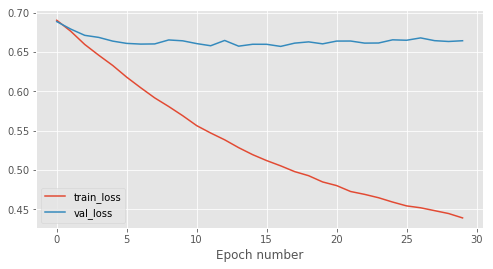

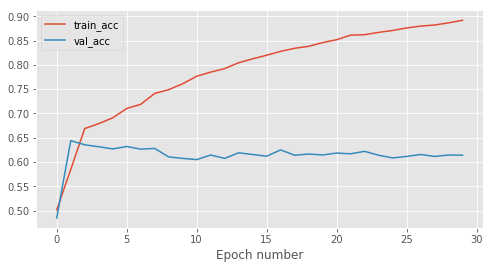

In [115]:
plot_stats_in_graph(total_losses)

In [20]:
# print(F.relu(Y_pred[0:500]))
m = nn.Softmax()
# Y_p = m(Y_pred)
# X_input.shape
# print(X_input[0,0,2,0:3])
# print(test_data.inputs[0,0,2,0:3])
print(Y_target[0:5])
print(np.argmax(Y_pred, axis=1)[0:5])
print(test_data.targets[0:5])

tensor([0, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0])
[0 0 1 0 0]


In [47]:
import os
import csv
csvfile = os.path.join(os.getcwd(), '../dataset/movie-test.csv')
with open(csvfile) as f:
    reader = csv.reader(f)
    X_list = [row for row in reader]

In [48]:
Y_pred_cl = np.argmax(Y_pred, axis=1)

for i in np.arange(2000):
    imdb_list = X_list[2*i]
    tmdb_list = X_list[2*i + 1]
#     print(X_list[2*i])
#     print(X_list[2*i + 1])
    for inputX, targetY, predY in zip(X_input, Y_target, Y_pred_cl):
        match_flag = True
        imdb_input = inputX[0]
        tmdb_input = inputX[1]
        if float(imdb_list[3]) != imdb_input[2][0] or \
            float(imdb_list[4]) != imdb_input[2][1] or \
            float(imdb_list[5]) != imdb_input[3][0] or \
            float(imdb_list[6]) != imdb_input[3][1] or \
            float(imdb_list[7]) != imdb_input[4][0] or \
            float(imdb_list[8]) != imdb_input[4][1] :
#             float(tmdb_list[3]) != tmdb_input[2][0] or \
#             float(tmdb_list[4]) != tmdb_input[2][1] or \
#             float(tmdb_list[5]) != tmdb_input[3][0] or \
#             float(tmdb_list[6]) != tmdb_input[3][1] or \
#             float(tmdb_list[7]) != tmdb_input[4][0] or \
#             float(tmdb_list[8]) != tmdb_input[4][1]:
#             print(imdb_list[3], imdb_input[2][0])
            match_flag = False
            continue
        if match_flag == True:
            
            print(i,targetY,predY)
            print(float(imdb_list[3]),imdb_input[2][0])
            print(float(imdb_list[4]),imdb_input[2][1])
            print(float(tmdb_list[3]),tmdb_input[2][0])
            print(float(tmdb_list[4]),tmdb_input[2][1])
            continue
    if i > 10:
        break

In [4]:
# X_input[0,0,2]
X_list[0:4]
# X_input.shape

In [116]:
from sklearn import metrics
# val_data.targets
# Y_pred.shape
# val_data.targets[0:50]
fpr, tpr, thresholds = metrics.roc_curve(Y_target, Y_pred[:,1])
# fpr, tpr, thresholds = metrics.roc_curve(Y_target, np.argmax(Y_pred, axis=1))

auc = metrics.auc(fpr, tpr)
auc
# metrics.f1_score(Y_target, np.argmax(Y_pred, axis=1))
# tpr
# thresholds
# metrics.roc_auc_score(Y_target, Y_pred)
# np.argmax(Y_pred, axis=1)

0.6809478530677611

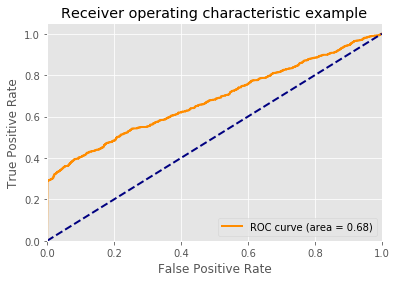

In [117]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [118]:
average_precision = metrics.average_precision_score(Y_target, Y_pred[:,1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

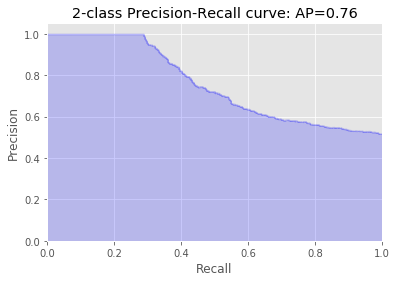

In [119]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(Y_target, Y_pred[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [25]:
def plot_confusion_matrix(cm, classes=None, norm=True, title='Confusion matrix', ax=None, **kwargs):
    """Plots a confusion matrix."""
    heatmap_kwargs = dict(annot=True, fmt='d')
    if norm:
        cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
        heatmap_kwargs['data'] = cm_norm
        heatmap_kwargs['vmin']=0.
        heatmap_kwargs['vmax']=1.
        heatmap_kwargs['fmt']='.3f'
    else:
        heatmap_kwargs['data'] = cm
    if classes is not None:
        heatmap_kwargs['xticklabels']=classes
        heatmap_kwargs['yticklabels']=classes
    if ax is None:
        ax = plt.gca()
    heatmap_kwargs['ax'] = ax
    heatmap_kwargs.update(kwargs)
    sns.heatmap(**heatmap_kwargs)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

Confusion Matrix: 
 [[725 245]
 [472 558]]


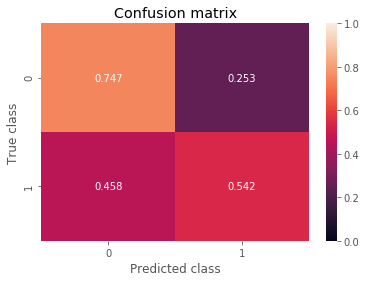

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from utils.plotter import scatter_jitter, plot_confusion_matrix

# print("The classification accuracy: ", gnb.score(X_train, y_train))
cm_train = confusion_matrix(Y_target, np.argmax(Y_pred, axis=1))
print("Confusion Matrix: \n", cm_train)
plot_confusion_matrix(cm_train, classes=[0,1])
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

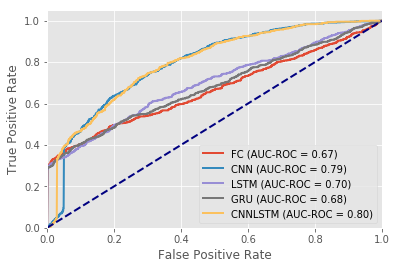

In [121]:



plt.figure()
lw = 2

Yt = Yt_LN
Yp = Yp_LN
fpr, tpr, thresholds = metrics.roc_curve(Yt, Yp[:,1])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, label='FC (AUC-ROC = %0.2f)' % auc)

Yt = Yt_CNN
Yp = Yp_CNN
fpr, tpr, thresholds = metrics.roc_curve(Yt, Yp[:,1])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, label='CNN (AUC-ROC = %0.2f)' % auc)

Yt = Yt_LSTM
Yp = Yp_LSTM
fpr, tpr, thresholds = metrics.roc_curve(Yt, Yp[:,1])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, label='LSTM (AUC-ROC = %0.2f)' % auc)

Yt = Yt_GRU
Yp = Yp_GRU
fpr, tpr, thresholds = metrics.roc_curve(Yt, Yp[:,1])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, label='GRU (AUC-ROC = %0.2f)' % auc)

Yt = Yt_CNNLSTM
Yp = Yp_CNNLSTM
fpr, tpr, thresholds = metrics.roc_curve(Yt, Yp[:,1])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, label='CNNLSTM (AUC-ROC = %0.2f)' % auc)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

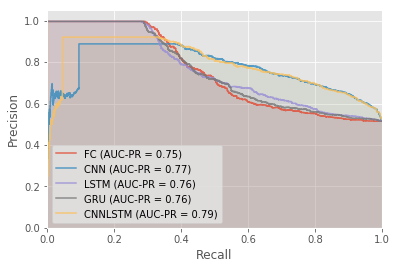

In [122]:
Yt = Yt_LN
Yp = Yp_LN
average_precision = metrics.average_precision_score(Yt, Yp[:,1])

precision, recall, _ = precision_recall_curve(Yt, Yp[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, alpha=0.8, where='post', label='FC (AUC-PR = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.1, **step_kwargs)

Yt = Yt_CNN
Yp = Yp_CNN
average_precision = metrics.average_precision_score(Yt, Yp[:,1])

precision, recall, _ = precision_recall_curve(Yt, Yp[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, alpha=0.8, where='post', label='CNN (AUC-PR = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.1, **step_kwargs)


Yt = Yt_LSTM
Yp = Yp_LSTM
average_precision = metrics.average_precision_score(Yt, Yp[:,1])

precision, recall, _ = precision_recall_curve(Yt, Yp[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, alpha=0.8, where='post', label='LSTM (AUC-PR = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.1, **step_kwargs)

Yt = Yt_GRU
Yp = Yp_GRU
average_precision = metrics.average_precision_score(Yt, Yp[:,1])

precision, recall, _ = precision_recall_curve(Yt, Yp[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, alpha=0.8, where='post', label='GRU (AUC-PR = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.1, **step_kwargs)

Yt = Yt_CNNLSTM
Yp = Yp_CNNLSTM
average_precision = metrics.average_precision_score(Yt, Yp[:,1])

precision, recall, _ = precision_recall_curve(Yt, Yp[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, alpha=0.8, where='post', label='CNNLSTM (AUC-PR = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.1, **step_kwargs)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))
plt.legend(loc='lower left')
plt.show()